In [10]:
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from matplotlib import pyplot as plt



# Task 1. Build and train a network to recognize digits


## 1. Build a network model - C


In [11]:
# This is a class for network with the following layers.

# CNN
# - A convolution layer with 10 5x5 filters
# - A max pooling layer with a 2x2 window and a ReLU function applied.

# - A convolution layer with 20 5x5 filters
# - A dropout layer with a 0.5 dropout rate (50%)
# - A max pooling layer with a 2x2 window and a ReLU 
# function applied

# RNN
# - A flattening operation followed by a fully
# connected Linear layer with 50 nodes and a ReLU function on the output
# - A final fully connected Linear layer with 10
# nodes and the log_softmax function applied to the output.

class NeuralNetwork(nn.Module):
    
    def __init__(self):
        # call the parent constructor
        super(NeuralNetwork, self).__init__()
        
        #1. CNN
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5) 
        
        # final output : 20 Channels X 4 X 4
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() # default is 0.5 or half
        
        #2. ANN
        self.fc1 = nn.Linear(in_features=320, out_features=50)
        self.fc2 = nn.Linear(50, 10)
        
        self.flatten = nn.Flatten()
     

    def forward(self, x):
        # 1. first conv, max pool, relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        
        # 2. 2nd conv, droptout layer, max pool, relu
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # 3. reshape tensor . Question: why to -1, 320. this is same as flatten
        x = x.view(-1, 320)
        
        # 4. fully connected, relu
        x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        # 5. convert the output from a Linear layer
        # into a categorical probability distribution
        return F.log_softmax(x, -1)

# TODO: Diagram of the network

## 2. Get the MNIST digit data set -A
The MNIST digit data consists of a training set of 60k 28x28 labeled digits and a test set of 10k 28x28 labeled digits. The data set can be imported directly from the torchvision package as torchvision.datasets.MNIST. Use the matplotlib pyplot package or OpenCV to look at the first six example digits. Look up examples that make use of the pyplot subplot method to create a grid of plots.

Include a plot of the first six example digits in your report.

In [12]:

# A function that takes in a boolean of whether or not it's a traning data 
# and set the batch number to 64 or 1000 for training or test respectively.
# it then creates a transform object for MNIST dataset that will be plugged in 
# to data loader. it will also transform the data 
# then return the dataloader

def get_loader(is_train):
    if(is_train):
        batch_num = 64
    else:
        batch_num = 1000
    
     # 1. transform the training input data to tensor and normalize it
    transform=torchvision.transforms.Compose(
                [torchvision.transforms.ToTensor(),
                 torchvision.transforms.Normalize(
                    # normalize with mean and std
                    (0.1307,), (0.3801,)
                )
                ])
    
    
    # 2. create a data loader
    data_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(
            'mnist',
            train=is_train,
            download=True,
            transform=transform),
        batch_size=batch_num,
        shuffle=False)

    # Enumerate on test loader will give me batch index 
    # the train loader itself returning the images(example_data) and the label for it (example_target)
    return data_loader


In [13]:

# A function that plot the first 6 sample images given a data loader
def display_sample_images(data_loader) :
    
    # get the X and y
    examples = enumerate(data_loader)
    batch_idx, (sample_data, sample_targets) = next(examples)
    
    # plot the first 6 sample
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.tight_layout()
        plt.imshow(sample_data[i][0], cmap="gray", interpolation="none")
        plt.title("Ground truth: %d" %(sample_targets[i]))
        plt.xticks([])
                  
    plt.show()

## 3. Train test and save the network - D, E

Train the model for five epochs, one epoch at a time, 
evaluating the model on both the training and test sets after each epoch. 

One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE. 

Since one epoch is too big to feed to the computer at once we divide it in several smaller batches.

Pick a batch size of your choice. 
Make a plot

In [14]:
# A function that takes in a network, a train data loader, and the number of epoch
# and train network per batch
# It will then save the state of the network in results folder

def train_network(network, train_loader, epoch_num):
    # 1. train mode
    network.train()
    
    # result to be plot
    train_losses = []
    train_counter = []
    
    # For each batch
    for batch_idx, (data, target) in enumerate(train_loader):
        # 2. Manually set the gradients to zero using optimizer.zero_grad() since PyTorch by default accumulates gradients.
        # use gradient descent
        learning_rate = 0.1
        momentum = 0.5
        optimizer = optim.SGD(network.parameters(), # learning parameters
                              lr=learning_rate,
                              momentum=momentum)

        optimizer.zero_grad()
        output = network(data)

        # 3. compute a negative log-likelihodd (nll) loss between the output and the ground truth label
        loss = F.nll_loss(output, target)
        loss.backward()

        # 4. The backward() call we now collect a new set of gradients
        # which we propagate back into each of the network's parameters using optimizer.step()
        optimizer.step()

        # 5. what is log_interval?
        print_interval = 10
        if batch_idx % print_interval == 0:
            # - print
            # print('Train Epoch: {}, batch index:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #     epoch_num,
            #     batch_idx,
            #     batch_idx * len(data),
            #     len(train_loader.dataset),
            #     100. * batch_idx / len(train_loader), loss.item()))
            
            # - append result per epoch to plot
            train_losses.append(loss.item())
            train_counter.append( # number of samples the model has seen
                (batch_idx*64) + ((epoch_num-1) * len(train_loader.dataset))
            )

            # - save network and optimizer
            torch.save(network.state_dict(), 'results/model.pth')
            torch.save(optimizer.state_dict(), 'results/optimizer.pth')
            
    # return the error value for each batch and the number of samples
    return train_counter, train_losses
            

In [19]:

# A function that takes in a network, a test dataloader.
# It sets the network to evaluation mode and run the network on test data
# it compute the loss and return it.
# test is done per epoch
def test_network(network, test_loader):
    network.eval()
    test_loss = 0
    correct_count = 0

    with torch.no_grad(): # disable gradient calculation

        # 1. run on test data 
        for data, target in test_loader:
            output = network(data)
            # get error
            test_loss += F.nll_loss(output, target, size_average=False).item()

            # get prediction
            pred = output.data.max(1, keepdim=True)[1]

            # get number of correct prediction per 1000 
            correct_count += pred.eq(target.data.view_as(pred)).sum()

        # 2. get error
        test_loss /= len(test_loader.dataset)

        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct_count, len(test_loader.dataset),
            100. * correct_count / len(test_loader.dataset)))

    return test_loss

In [20]:

# Given the list of count of sample images seen in train and test data
# and the list of loss in each batch of train and in each epoch of test
# it will plot the graph of the number of seen data against the loss score.

def plot_result(train_counter, train_losses, test_counter, test_losses):
    plt.figure(figsize=(10,10))
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    
    

In [21]:
def main(argv):
    # set the device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 1. make network reproducible
    torch.manual_seed(42)
    torch.backends.cudnn.enabled = False

    # 2. load and plot data
    train_loader = get_loader(is_train=True)
    test_loader = get_loader(is_train=False)
    display_sample_images(train_loader)
    display_sample_images(test_loader)

    # 3. create network model
    network = NeuralNetwork()

    # 4. train and test network model
    epoch_num = 5

    # create list to plot the number of training samples on x axis, and the scores
    train_counter_per_epoch = []
    train_counter = []
    train_losses = []

    test_losses = []
    test_counter = [i * len(train_loader.dataset) for i in range(epoch_num + 1)]
    test_losses.append(0)

    for epoch in range(1, epoch_num + 1):
        # - train and get counter and loss list
        train_counter_per_epoch, train_loss_per_epoch = train_network(
            network, train_loader, epoch)

        train_counter.append(train_counter_per_epoch)
        train_losses.append(train_loss_per_epoch)

        # - test
        test_losses.append(test_network(network, test_loader))


    # 5. flatten the two arrays
    # for all the sublist in regular list,
    # get all the sub item in sublist
    flat_train_counter = [single_item for sublist in train_counter
                        for single_item in sublist]


    flat_train_losses = [single_item for sublist in train_losses
                        for single_item in sublist]
    
    # 6. plot result
#     print("test counter shape:", len(test_counter), "value:", test_counter)
#     print("test loss shape:", len(test_losses), "value:", test_losses)

#     print("train counter shape:", len(flat_train_counter))
#     print("train loss shape:", len(flat_train_losses))
    plot_result(flat_train_counter, flat_train_losses, test_counter, test_losses)

    
    

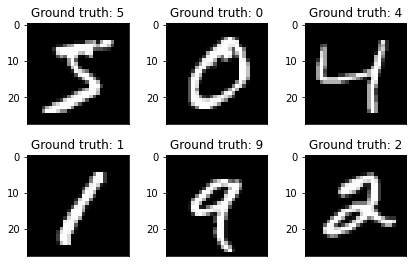

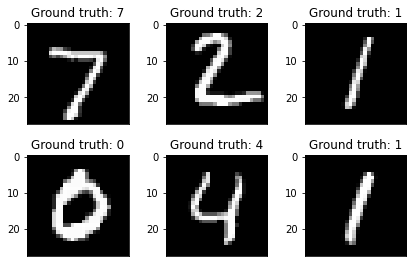

/var/folders/76/26vt73dx7psbzwyygdm5wtt40000gn/T/ipykernel_2686/3419677037.py:55: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.0899, Accuracy: 9727/10000 (97%)


Test set: Avg. loss: 0.0679, Accuracy: 9778/10000 (98%)


Test set: Avg. loss: 0.0566, Accuracy: 9813/10000 (98%)


Test set: Avg. loss: 0.0461, Accuracy: 9850/10000 (98%)


Test set: Avg. loss: 0.0414, Accuracy: 9860/10000 (99%)



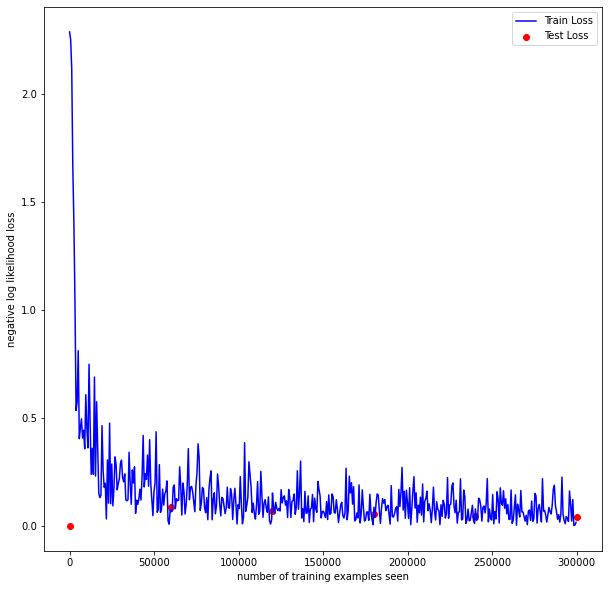

In [22]:
if __name__ == "__main__":
    main(sys.argv)

In [ ]:
# Question. how to draw the first test loss ?

In [23]:
torch.cuda.is_available()

False